# CO2 emissions vs. GDP Uniview Visualization

This notebook generates a bubble chart illustrating how CO2 emissions and GDP have varied over the past 60 years in the World's Major carbon emitters. The data set are downloaded from http://gapminder.org and the style of the plot is borrowed from them as well. The the ten top Carbon emitters in 2011 were included, as were two countries (the UK and France) that were in the top five in 1950, but have since dropped out of the top ten in emmissions. One country (South Korea) was excluded dure to missing data).

#### For reference see Hans Rosling's famous TED talk

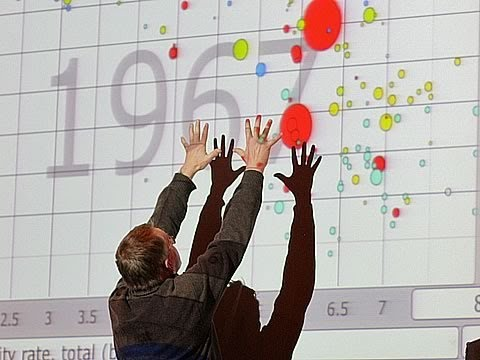

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('hVimVzgtD6w')

### Imports and function definitions

In [2]:
#This directory contains all the data needed for the module. It should be in the same directory as the notebook
dataFolder = "data" 
import sys, os, shutil, errno, string, urllib.request, math, copy
sys.path.append(( os.path.abspath( os.path.join(os.path.realpath("__file__"), os.pardir, os.pardir) )))
import uvmodlib.v1 as uvmod
from config import Settings


import pandas as pd
import matplotlib as plt
from PIL import Image

### USES Conf Template for Gapminder.org style Bubble Chart

In [157]:
BubbleChartTemplate = """mesh
{
    data  graph ./modules/$folderName/shaders/graph.obj 
    glslVersion 330 
    enableTypeCheck true
    
    propertyCollection
    {
        __objectName__
        {
            vec3f chartOffset $chartOffset
            vec1i chartMask $chartMask
            bool chartCrumbs $chartCrumbs
            vec1f chartHighlight $chartHighlight
        }
    }

    pass
    {
        useDataObject graph
        shader
        {
            type defaultMeshShader
            {
                vertexShader ./modules/$folderName/shaders/CO2_graph_vertex.glsl
                fragmentShader ./modules/$folderName/shaders/CO2_graph_fragment.glsl
                StateManagerVar __objectName__.chartOffset heightOffset
                StateManagerVar __objectName__.Alpha alpha
                StateManagerVar __objectName__.chartMask showMask
                StateManagerVar __objectName__.chartCrumbs breadCrumbs
                StateManagerVar __objectName__.chartHighlight highlight
                
                texture countryLabels ./modules/$folderName/images/CountryLabels.png
                {
                }
                texture Numbers ./modules/$folderName/images/BigNumbers.png
                {
                    wrapModeS GL_CLAMP_TO_EDGE
                    wrapModeR GL_CLAMP_TO_EDGE
                }
                texture co2Lab ./modules/$folderName/images/co2pcLab.png
                {
                    wrapModeS GL_CLAMP_TO_EDGE
                    wrapModeR GL_CLAMP_TO_EDGE
                }
                texture gdpLab ./modules/$folderName/images/gdpLab.png
                {
                    wrapModeS GL_CLAMP_TO_EDGE
                    wrapModeR GL_CLAMP_TO_EDGE
                }
                texture co2pcData ./modules/$folderName/images/CO2perCap.png
                {
                    wrapModeS GL_CLAMP_TO_EDGE
                    wrapModeR GL_CLAMP_TO_EDGE
                }
                texture co2totData ./modules/$folderName/images/CO2total.png
                {
                    wrapModeS GL_CLAMP_TO_EDGE
                    wrapModeR GL_CLAMP_TO_EDGE
                }
                texture gdpData ./modules/$folderName/images/GDPperCap.png
                {
                    wrapModeS GL_CLAMP_TO_EDGE
                    wrapModeR GL_CLAMP_TO_EDGE
                }
                glState
                {
                    # additive blending
                    UV_BLEND_FUNC GL_SRC_ALPHA GL_ONE_MINUS_SRC_ALPHA
                    UV_DEPTH_ENABLE true
                    UV_BLEND_ENABLE true
                    UV_WRITE_MASK_DEPTH true
                    UV_CULL_FACE_ENABLE false
                }
            }
        }
    }

}"""

### Bubble Chart Class

In [161]:
class BubbleChart():
    def __init__(self, object):
        self.object = object
        uvmod.Utility.ensurerelativepathexsists("shaders\\graph.obj",dataFolder)
        uvmod.Utility.ensurerelativepathexsists("shaders\\CO2_graph_fragment.glsl",dataFolder)
        uvmod.Utility.ensurerelativepathexsists("shaders\\CO2_graph_vertex.glsl",dataFolder)
        self.Alpha = 1
        self.chartOffset = "0.0 0.0 1.5"
        self.chartMask = 0
        self.chartCrumbs = False
        self.chartHighlight = 0.75
    def setChartOffset(self,chartOffset):
        self.ColorMultiplier = " ".join(str(c) for c in chartOffset)
    def setAlpha(self,Alpha):
        self.Alpha = Alpha
    def generatemod(self):
        self.object.setgeometry(self.object.name+".usesconf")
        return self.object.generatemod()
    def generatefiles(self, absOutDir, relOutDir):
        fileName = self.object.name+".usesconf"
        s = string.Template(BubbleChartTemplate)
        f = open(absOutDir+"\\"+fileName, 'w')
        if f:
            f.write(s.substitute(folderName = relOutDir,
                                 chartOffset = self.chartOffset,
                                chartMask = self.chartMask,
                                chartCrumbs = self.chartCrumbs,
                                chartHighlight = self.chartHighlight))
            f.close()
        uvmod.Utility.copyfoldercontents(os.getcwd()+"\\"+dataFolder, absOutDir)

### Object Instantiation

In [162]:
model = BubbleChart(uvmod.OrbitalObject())
generator = uvmod.Generator()
scene = uvmod.Scene()
modinfo = uvmod.ModuleInformation()

### Specify Settings and generate the module

In [163]:
scene.setname("CO2gapminder")
scene.setparent("Earth")
scene.setentrydist(100000)
scene.setunit(1.)
#scene.setsurfacepositionerrotation(180.,0,0)
#scene.setpositionfile(uvmod.PositionFileTypes.Surface("Earth",  -70.572560, 66.674812, .42))

model.object.setcameraradius(30)
model.object.setcoord("Earth")
model.object.setname("CO2gapminder")
model.object.setguiname("/Solar System/Planets/Earth/CO2 Bubble Chart")
model.object.settargetradius(300)
model.object.setscalefactor(655)
modinfo.setname("CO2 Bubble Chart")
modinfo.setauthor("Mark SubbaRao<br />Adler Planetarium")
modinfo.cleardependencies()
modinfo.adddependency("Earth")
modinfo.setdesc("A module animating per capita CO2 emissions vs per capita GDPdata and style taked from gapminder.org")
modinfo.setthumbnail("data/images/thumbnail.png")
modinfo.setversion("1.0")

generator.generate("CO2gapminder",[],[model],modinfo)

## Read datafiles and make texture images encoding data

In [9]:
def makeImage(ds,maxVal,imageName):
    countryOrder=['United States','Russia','China','India','Canada','Japan','Germany','Iran','South Africa','France','United Kingdom']
    im=Image.new("RGB",(62,11))
    for i,country in enumerate(countryOrder):
        for j,year in enumerate(range(1950,2012)):
            val = ds.fillna(0)[year][country]/maxVal
            valR = int(256*val)
            valG = int(256*256*(val-valR/256.))
            valB = int(256*256*256*(val-valR/256.-valG/(256.*256.)))
            im.putpixel((j,i),(valR,valG,valB))
    im.save(imageName)

### CO2 per capita data

Data Source: CDIAC (Carbon Dioxide Information Analysis Center) http://cdiac.ornl.gov/trends/emis/meth_reg.html

 

In [160]:
Co2perCapTable=pd.pandas.read_excel('rawdata/indicator CDIAC carbon_dioxide_emissions_per_capita.xlsx',index_col=0)

sCO2perCap=Co2perCapTable.ix[['Russia','China','India','United States','United Kingdom','Japan','Germany','Iran'
                ,'South Africa','France','Canada'],1950:2011]

In [161]:
sCO2perCap.max().max()

22.167963404044698

In [162]:
# We will use a value of 25.0 as the maxVal and write the image
makeImage(sCO2perCap,25.0,Settings.uvcustommodulelocation+'\\'+model.object.name+'\\images\\CO2perCap.png')

### Total CO2 emissions

Data Source: CDIAC (Carbon Dioxide Information Analysis Center) http://cdiac.ornl.gov/trends/emis/meth_reg.html


In [163]:
Co2TotalTable=pd.pandas.read_excel('rawdata\\indicator CDIAC carbon_dioxide_total_emissions.xlsx',index_col=0)
# This table lists 'USSR' up to 1992 and 'Russia' afterwards, we will merge them both under 'Russia'
sCO2Total=Co2TotalTable.ix[['Russia','USSR','China','India','United States','United Kingdom','Japan','Germany','Iran'
                ,'South Africa','France','Canada'],1950:2011]

sCO2Total=sCO2Total.rename(index={'USSR':'Russia'})
sCO2Total=sCO2Total.groupby(sCO2Total.index).sum()

In [164]:
sCO2Total.max().max()

9110978.8010000009

In [165]:
# Will use 10,000,000 as the maxVal
makeImage(sCO2Total,10000000.0,Settings.uvcustommodulelocation+'\\'+model.object.name+'\\images\\CO2total.png')

### Per Capita GDP

Data compiled from multiple sources by Mattias Lindgren, Gapminder. Full details are described here:
http://www.gapminder.org/downloads/documentation/gd001



In [73]:
GDPperCapitaTable=pd.pandas.read_excel('rawdata/indicator gapminder gdp_per_capita_ppp.xlsx',index_col=0)
sGDPperCapitaTable=GDPperCapitaTable.ix[['Russia','China','India','United States','United Kingdom','Japan','Germany','Iran'
                ,'South Africa','France','Canada'],1950:2011]

In [74]:
sGDPperCapitaTable.max().max()

51011.0

In [77]:
# We will use 55,000 as the maxVal
makeImage(sGDPperCapitaTable,55000.0,Settings.uvcustommodulelocation+'\\'+model.object.name+'\\images\\GDPperCap.png')

### Helper Functions for modifing code
##### Reload Module and Shaders in Uniview

In [46]:
uvmod.Utility.senduvcommand(model.object.name+".reload; system.reloadallshaders")

##### Copy modified Shader files and reload

In [185]:
uvmod.Utility.copyfoldercontents(os.getcwd()+"\\"+dataFolder+'\\shaders', Settings.uvcustommodulelocation+'\\'+model.object.name+'\\shaders')
uvmod.Utility.senduvcommand(model.object.name+".reload; system.reloadallshaders")

Unable to connect to Uniview
